In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# from torch.autograd import Variable
# from torch.utils.data import Subset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# Dataset loading (replace 'your_dataset.csv' with the actual path)
def load_data(data_path):
    try:
        df = pd.read_csv(data_path)
        return df
    except FileNotFoundError:
        print("Error: Dataset file not found. Please provide the correct path.")
        return None
df = load_data("./card_transaction.v1.csv")

df = df.dropna(subset=['Is Fraud?'])

df.head()

,User,Card,Year,Month,Day,Time,Amount,Use Chip,Merchant Name,Merchant City,Merchant State,Zip,MCC,Errors?,Is Fraud?
0,0,0,2002,9,1,06:21,$134.09,Swipe Transaction,3.527213e+18,La Verne,CA,91750.0,5300.0,NaN,No
1,0,0,2002,9,1,06:42,$38.48,Swipe Transaction,-7.276121e+17,Monterey Park,CA,91754.0,5411.0,NaN,No
2,0,0,2002,9,2,06:22,$120.34,Swipe Transaction,-7.276121e+17,Monterey Park,CA,91754.0,5411.0,NaN,No
3,0,0,2002,9,2,17:45,$128.95,Swipe Transaction,3.414527e+18,Monterey Park,CA,91754.0,5651.0,NaN,No
4,0,0,2002,9,3,06:23,$104.71,Swipe Transaction,5.817218e+18,La Verne,CA,91750.0,5912.0,NaN,No


In [3]:
original_col_order = df.columns.to_list()

In [4]:
df['Is Fraud?'].notna().sum()

2555189

In [5]:
column_name = 'Errors?'
unique_values = df[column_name].unique()
l=[]
for i in unique_values:
  if type(i)!=float :
    a=i.split(',')
    for j in a:
      if j!='':
        l.append('errors_' + j)
# print(set(l))
unique_values = set(l)

i=0
unique_dict = dict()
for j in unique_values:
  unique_dict[j] = i
  i+=1
# print(unique_dict)

column_list = df[column_name].tolist()
d = dict()
for i in unique_values:
  d[i]=[0]*(len(column_list))

cnt=0
for i in column_list:
  if type(i)!=float:
    g=i.split(',')
    for j in g:
      if j!='':
        d['errors_' + j][cnt]=1
  cnt+=1

df = df.assign(**d)

In [6]:
# encoder = OneHotEncoder(sparse=False)
# encoded_categories = encoder.fit_transform(df[['Use Chip']])
# encoded_df = pd.DataFrame(encoded_categories, columns=encoder.get_feature_names_out(['Use Chip']))


df['Time'] = df['Time'].apply(lambda x: x + ':00' if ':' not in x else x)
df['datetime_str'] = df['Year'].astype(str) + '-' + df['Month'].astype(str).str.zfill(2) + '-' + df['Day'].astype(str).str.zfill(2) + ' ' + df['Time']
df['datetime'] = pd.to_datetime(df['datetime_str'], format='%Y-%m-%d %H:%M')

datetime_minval = df['datetime'].min()

df['datetime'] = (df['datetime'] - df['datetime'].min()).dt.total_seconds()


df['Amount'] = df['Amount'].str.replace('$', '')
df['Amount'] = df['Amount'].astype(float)

label_encoder1 = LabelEncoder()
df['Merchant City'] = label_encoder1.fit_transform(df['Merchant City'])

label_encoder2 = LabelEncoder()
df['Merchant State'] = label_encoder2.fit_transform(df['Merchant State'])


label_encoder3 = LabelEncoder()
df['Zip'] = label_encoder3.fit_transform(df['Zip'])

df['Is Fraud?'] = df['Is Fraud?'].map({'Yes': True, 'No': False})

one_hot_encoded1 = pd.get_dummies(df['Use Chip'], prefix='chip')

df = pd.concat([df, one_hot_encoded1], axis=1)


df.drop(columns=['Year', 'Month', 'Day', 'Time', 'datetime_str', 'Use Chip', 'Errors?'], inplace=True)

In [7]:
max_merchant_city = df['Merchant City'].max()
max_merchant_state = df['Merchant State'].max()
max_zip = df['Zip'].max()

In [8]:
df['datetime'].isna().sum()

0

In [9]:
df = df.astype('Float64')

In [10]:
scaler = MinMaxScaler()

# Fit and transform the DataFrame
df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

X_train, X_testval = train_test_split(df, test_size=0.3, random_state=42)
X_test, X_val = train_test_split(X_testval, test_size=0.5, random_state=42)

# list_of_lists = df.values.tolist()

# Convert list of lists into a tensor
X_train_tensor = torch.tensor(X_train.values.tolist()).to(device)
X_test_tensor = torch.tensor(X_test.values.tolist()).to(device)
X_val_tensor = torch.tensor(X_val.values.tolist()).to(device)

In [11]:
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()
        # self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc1 = nn.Linear(input_dim, hidden_dim*4)
        self.fc11 = nn.Linear(hidden_dim*4, hidden_dim*2)
        self.fc111 = nn.Linear(hidden_dim*2, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, latent_dim)
        self.fc22 = nn.Linear(hidden_dim, latent_dim)
        self.fc3 = nn.Linear(latent_dim, hidden_dim*2)
        # self.fc3 = nn.Linear(latent_dim, hidden_dim)
        self.fc44 = nn.Linear(hidden_dim*2, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, input_dim)
        # self.fc4 = nn.Linear(hidden_dim, input_dim)

    def encode(self, x):
        # h1 = F.relu(self.fc1(x))
        # h1 = F.relu(self.fc11(self.fc1(x)))
        h1 = F.relu(self.fc111(self.fc11(self.fc1(x))))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(self.fc44(h3)))
        # return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

def loss_function(recon_x, x, mu, logvar):
    MSE = F.mse_loss(recon_x, x)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return MSE + KLD

input_dim = X_train_tensor.shape[1]
hidden_dim = 350
latent_dim = 5
model = VAE(input_dim, hidden_dim, latent_dim).to(device)

#Rprop converges faster than Adam
optimizer = optim.Rprop(model.parameters(), lr=1e-3)

batch_size = 50000
n_batches = (X_train_tensor.size(0) + batch_size - 1) // batch_size  # Calculate how many batches are needed

def train(epoch):
    model.train()
    for e in range(epoch):
        train_loss = 0
        for i in range(n_batches):
            start = i * batch_size
            end = start + batch_size
            data = X_train_tensor[start:end].to(device)
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(data)
            loss = loss_function(recon_batch, data, mu, logvar)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()
            
        recon_batch_val, mu, logvar = model(X_val_tensor)
        loss_val = loss_function(recon_batch_val, X_val_tensor, mu, logvar)
        print(f'epoch: {e} loss: {loss_val}')
# Training the model
num_epochs = 100
log_interval = 1000
# for epoch in range(1, num_epochs + 1):
train(10)


epoch: 0 loss: 2.301227331161499


In [12]:
recon_test, mu, logvar = model(X_test_tensor)
loss_test = loss_function(recon_test, X_test_tensor, mu, logvar)
print(f'test loss: {loss_test}')

test loss: 0.22251418232917786


In [14]:
with torch.no_grad():
    num_samples = 2000000  # 2million transactions
    latent_samples = torch.randn(num_samples, latent_dim).to('cpu')  # Sample from the latent space
    model = model.to('cpu')
    synthetic_data = model.decode(latent_samples)

In [15]:
test_reconstructed = pd.DataFrame(recon_test.cpu().detach().numpy(), columns=X_train.columns)

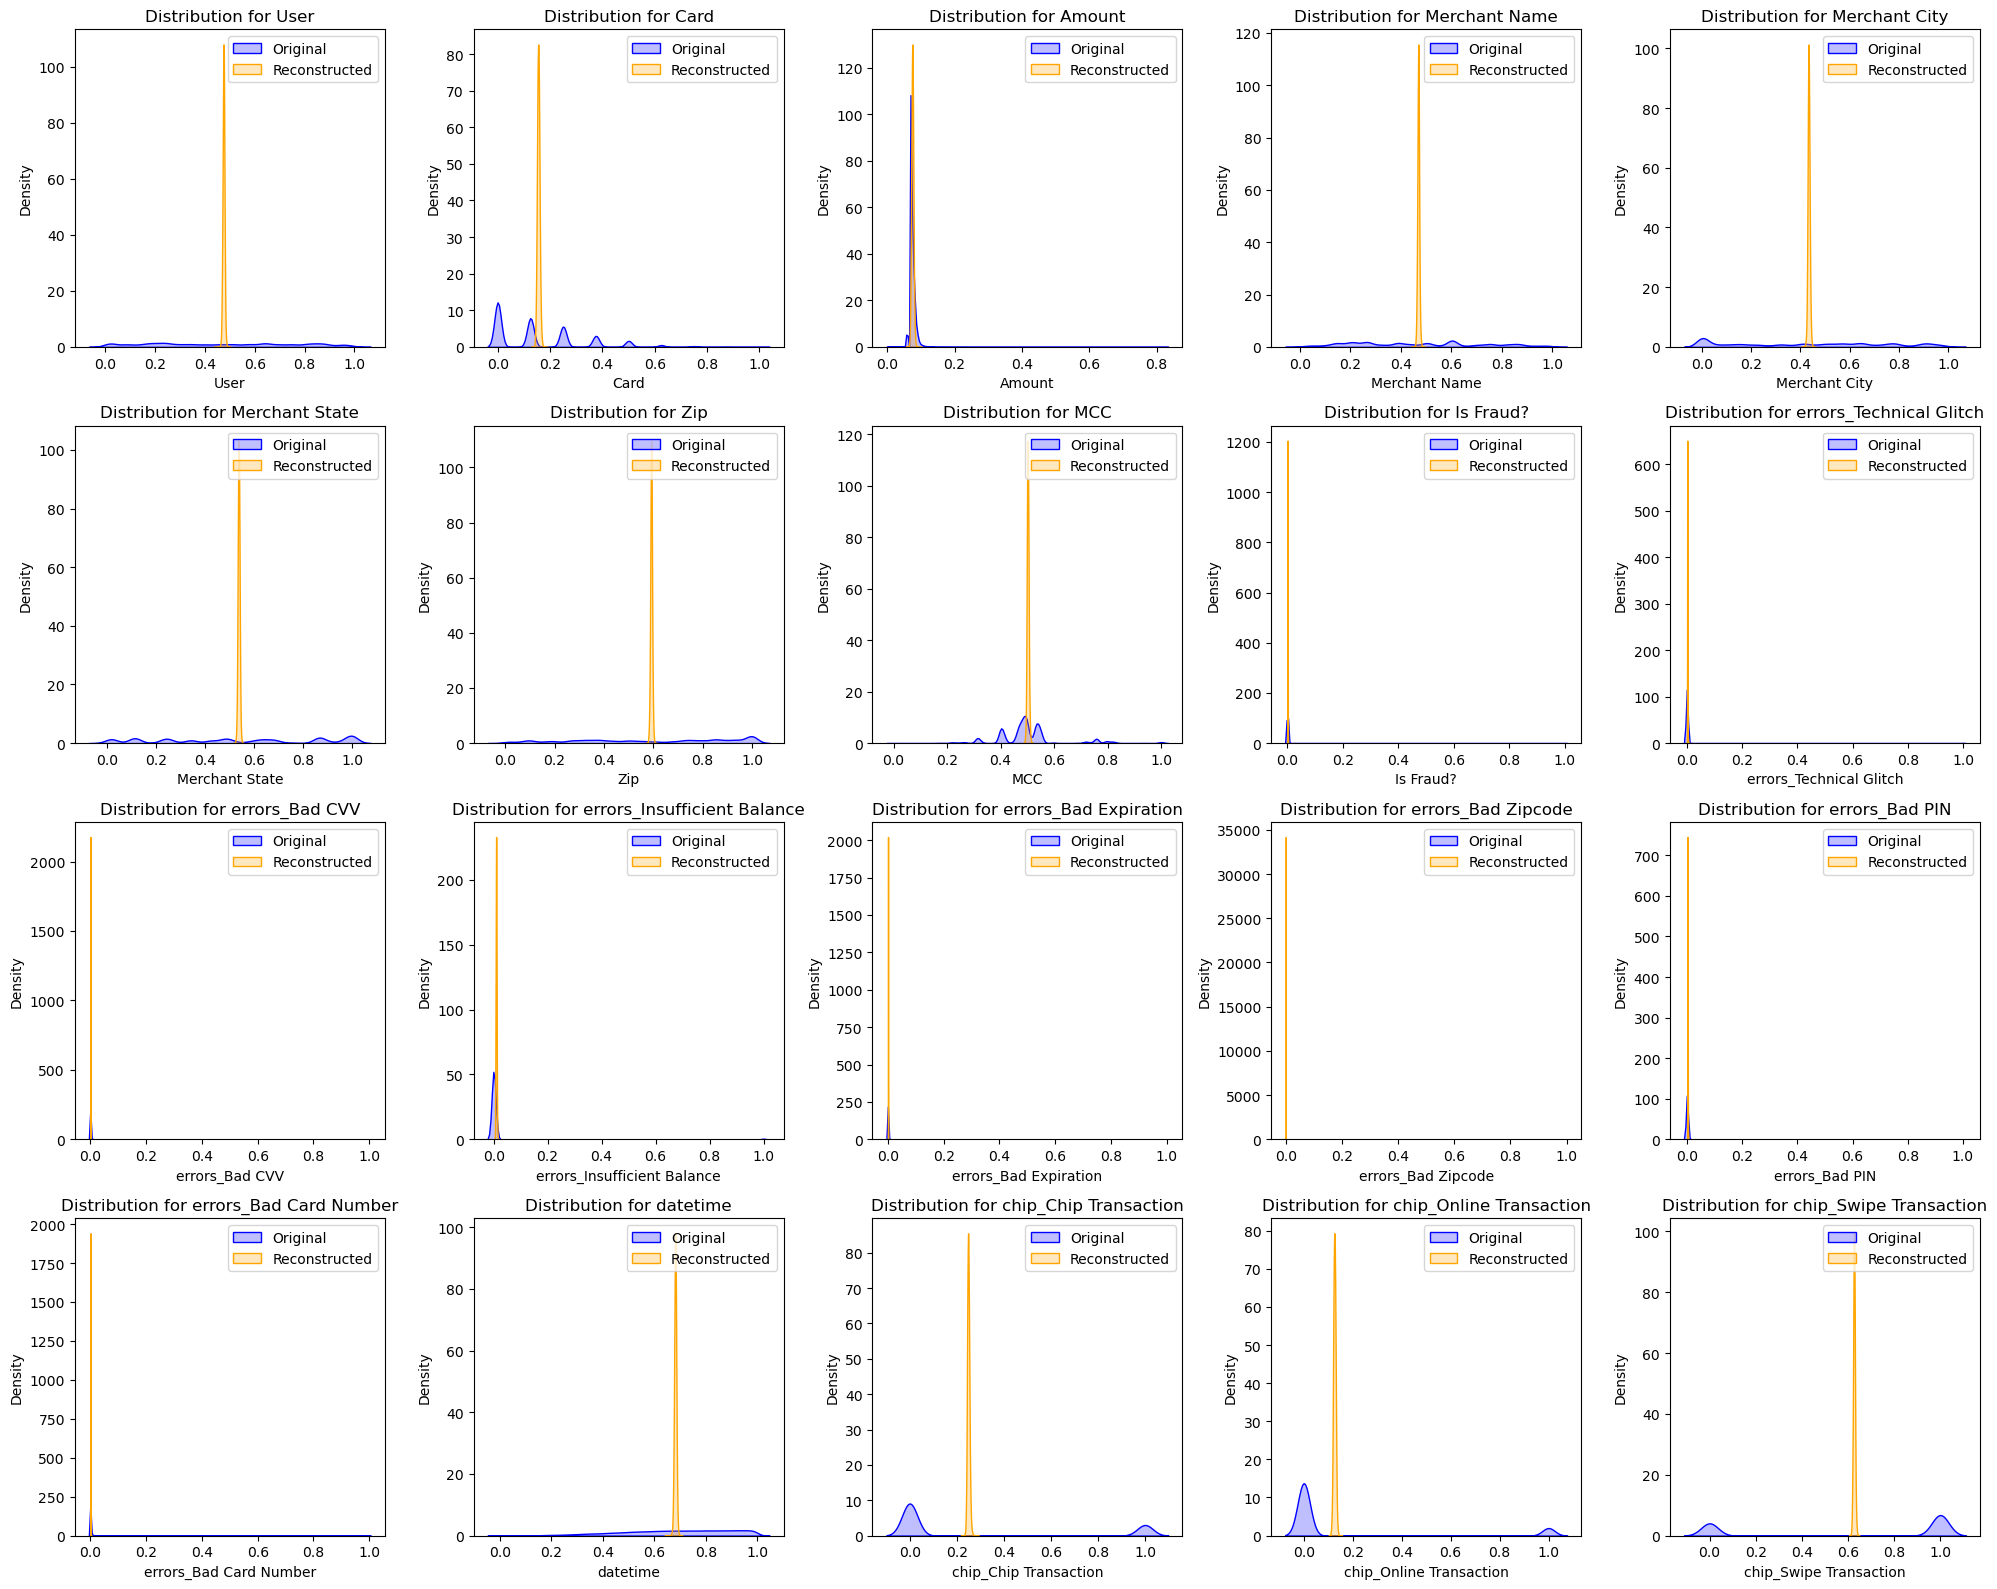

In [18]:
fig, axs = plt.subplots(4, 5, figsize=(20, 16))

# Flatten the 2D list of axes for easy iteration
axs = axs.flatten()

# Plot PDFs for each column
for i, col in enumerate(X_train.columns.to_list()):
    sns.kdeplot(X_test[col], ax=axs[i], label='Original', color='blue', fill=True)
    sns.kdeplot(test_reconstructed[col], ax=axs[i], label='Reconstructed', color='orange', fill=True)
    
    axs[i].set_title(f'Distribution for {col}')
    axs[i].set_xlabel(col)
    axs[i].set_ylabel('Density')
    axs[i].legend()

# Remove any unused subplots
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()

In [19]:
df = pd.DataFrame(scaler.inverse_transform(synthetic_data.cpu().detach().numpy()), columns=X_train.columns)
# df = pd.DataFrame(scaler.inverse_transform(recon_batch_test.cpu().detach().numpy()), columns=X_train.columns)
df

,User,Card,Amount,Merchant Name,Merchant City,Merchant State,Zip,MCC,Is Fraud?,errors_Technical Glitch,errors_Bad CVV,errors_Insufficient Balance,errors_Bad Expiration,errors_Bad Zipcode,errors_Bad PIN,errors_Bad Card Number,datetime,chip_Chip Transaction,chip_Online Transaction,chip_Swipe Transaction
0,103.431946,1.233445,35.257263,-5.426988e+17,3466.059570,75.858482,9120.769531,5553.065918,0.000703,0.000909,0.000614,0.006446,0.000512,0.000032,0.001362,0.000569,529551392.0,0.253886,0.121648,0.624247
1,101.525658,1.191022,-6.385628,-5.437619e+17,3353.823242,76.513039,9240.289062,5563.360840,0.000968,0.001763,0.000366,0.005792,0.000451,0.000028,0.001875,0.000436,536022624.0,0.236526,0.116805,0.637816
2,102.999863,1.166700,13.669017,-5.460762e+17,3436.272705,77.030342,9075.685547,5549.628906,0.000529,0.000950,0.000182,0.007518,0.000140,0.000009,0.001491,0.000233,533244960.0,0.242847,0.117023,0.637754
3,103.397125,1.255385,76.658272,-4.796610e+17,3409.300781,76.644814,9083.746094,5551.324707,0.001282,0.002425,0.000449,0.012196,0.000436,0.000015,0.002710,0.000413,530656704.0,0.250671,0.128940,0.628661
4,102.147575,1.244718,36.873604,-5.919730e+17,3437.373047,78.034561,8973.580078,5563.339844,0.000878,0.001819,0.000370,0.009265,0.000349,0.000019,0.002121,0.000401,532835936.0,0.248272,0.122639,0.625209
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1999995,101.634438,1.168956,8.035389,-5.652418e+17,3456.802490,78.436569,9081.061523,5552.608398,0.000857,0.001259,0.000354,0.012243,0.000289,0.000022,0.001649,0.000363,531788192.0,0.247154,0.121612,0.631182
1999996,102.361992,1.279003,70.637138,-6.133457e+17,3408.405762,76.827820,9115.092773,5540.393066,0.001585,0.002889,0.000652,0.012275,0.000667,0.000030,0.003082,0.000767,532675904.0,0.250122,0.131478,0.621880
1999997,101.661026,1.308166,77.269554,-4.768328e+17,3443.177734,76.416565,9032.098633,5595.119629,0.001269,0.001999,0.000670,0.010355,0.000560,0.000072,0.002512,0.001001,520085312.0,0.256816,0.135698,0.630703
1999998,101.235863,1.277203,45.482918,-5.648092e+17,3444.848877,77.347206,9050.046875,5558.835938,0.001502,0.002305,0.000864,0.011406,0.000789,0.000050,0.002679,0.000898,526494272.0,0.249165,0.129224,0.626296


In [20]:
# import ast

df['datetime'] = datetime_minval + pd.to_timedelta(df['datetime'] , unit='s')

df['Year'] = df['datetime'].dt.year
df['Month'] = df['datetime'].dt.month
df['Day'] = df['datetime'].dt.day
df['Time'] = df['datetime'].dt.strftime('%H:%M')

chip_columns = df.filter(regex='^chip').columns.to_list()
df['Use Chip'] = df[chip_columns].idxmax(axis=1).apply(lambda x: x.replace('chip_', ''))

df['Is Fraud?'] = df['Is Fraud?'].apply(lambda x: 0 if x < 0.5 else 1)
df['Is Fraud?'] = df['Is Fraud?'].map({1 : 'Yes', 0 : 'No'})

error_columns = df.filter(regex='^errors').columns.to_list()
df['Errors?'] = df[error_columns].apply(lambda row: ', '.join(sorted(row.index[row == 1])), axis=1)
# df['Errors?'] = df['Error_Category'].apply(lambda x: x.replace('errors_', ''))
df['Errors?'] = df['Errors?'].apply(lambda x: x.replace('errors_', ''))
df['Errors?'].replace('', np.nan, inplace=True)

# print(error_columns)
df.drop(error_columns, axis=1, inplace = True)
df.drop(chip_columns, axis=1, inplace = True)
df.drop('datetime', axis=1,inplace= True)

df['Amount'] = '$' + df['Amount'].astype(str)

df['Merchant City'] = np.rint(df['Merchant City']).clip(0, max_merchant_city).astype(np.int32)
df['Merchant State'] = np.rint(df['Merchant State']).clip(0, max_merchant_state).astype(np.int32)
df['Zip'] = np.rint(df['Zip']).clip(0, max_zip).astype(np.int32)

df['Merchant City'] = label_encoder1.inverse_transform(df['Merchant City'])
df['Merchant State'] = label_encoder2.inverse_transform(df['Merchant State'])
df['Zip'] = label_encoder3.inverse_transform(df['Zip'])

In [21]:
df = df.reindex(columns = original_col_order)
df

,User,Card,Year,Month,Day,Time,Amount,Use Chip,Merchant Name,Merchant City,Merchant State,Zip,MCC,Errors?,Is Fraud?
0,103.431946,1.233445,2012,3,29,21:01,$35.257263,Swipe Transaction,-5.426988e+17,John Day,Macedonia,57031.0,5553.065918,NaN,No
1,101.525658,1.191022,2012,6,12,18:35,$-6.385628,Swipe Transaction,-5.437619e+17,Indiantown,Malaysia,59479.0,5563.360840,NaN,No
2,102.999863,1.166700,2012,5,11,15:01,$13.669017,Swipe Transaction,-5.460762e+17,Java Village,Malaysia,56443.0,5549.628906,NaN,No
3,103.397125,1.255385,2012,4,11,16:03,$76.65827,Swipe Transaction,-4.796610e+17,Iuka,Malaysia,56468.0,5551.324707,NaN,No
4,102.147575,1.244718,2012,5,6,21:23,$36.873604,Swipe Transaction,-5.919730e+17,Jay,Maldives,55902.0,5563.339844,NaN,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1999995,101.634438,1.168956,2012,4,24,18:21,$8.035389,Swipe Transaction,-5.652418e+17,Jersey Shore,Maldives,56464.0,5552.608398,NaN,No
1999996,102.361992,1.279003,2012,5,5,00:56,$70.63714,Swipe Transaction,-6.133457e+17,Ithaca,Malaysia,56762.0,5540.393066,NaN,No
1999997,101.661026,1.308166,2011,12,11,07:33,$77.269554,Swipe Transaction,-4.768328e+17,Jeffersonville,Macedonia,56219.0,5595.119629,NaN,No
1999998,101.235863,1.277203,2012,2,23,11:49,$45.482918,Swipe Transaction,-5.648092e+17,Jena,Malaysia,56292.0,5558.835938,NaN,No


In [22]:
df.to_csv('2M_synthetic.csv')

In [28]:
df = pd.DataFrame(scaler.inverse_transform(recon_test.cpu().detach().numpy()), columns=X_train.columns)

df['datetime'] = datetime_minval + pd.to_timedelta(df['datetime'] , unit='s')

df['Year'] = df['datetime'].dt.year
df['Month'] = df['datetime'].dt.month
df['Day'] = df['datetime'].dt.day
df['Time'] = df['datetime'].dt.strftime('%H:%M')

chip_columns = df.filter(regex='^chip').columns.to_list()
df['Use Chip'] = df[chip_columns].idxmax(axis=1).apply(lambda x: x.replace('chip_', ''))

df['Is Fraud?'] = df['Is Fraud?'].apply(lambda x: 0 if x < 0.5 else 1)
df['Is Fraud?'] = df['Is Fraud?'].map({1 : 'Yes', 0 : 'No'})

error_columns = df.filter(regex='^errors').columns.to_list()
df['Errors?'] = df[error_columns].apply(lambda row: ', '.join(sorted(row.index[row == 1])), axis=1)
# df['Errors?'] = df['Error_Category'].apply(lambda x: x.replace('errors_', ''))
df['Errors?'] = df['Errors?'].apply(lambda x: x.replace('errors_', ''))
df['Errors?'].replace('', np.nan, inplace=True)

# print(error_columns)
df.drop(error_columns, axis=1, inplace = True)
df.drop(chip_columns, axis=1, inplace = True)
df.drop('datetime', axis=1,inplace= True)

df['Amount'] = '$' + df['Amount'].astype(str)

df['Merchant City'] = np.rint(df['Merchant City']).clip(0, max_merchant_city).astype(np.int32)
df['Merchant State'] = np.rint(df['Merchant State']).clip(0, max_merchant_state).astype(np.int32)
df['Zip'] = np.rint(df['Zip']).clip(0, max_zip).astype(np.int32)

df['Merchant City'] = label_encoder1.inverse_transform(df['Merchant City'])
df['Merchant State'] = label_encoder2.inverse_transform(df['Merchant State'])
df['Zip'] = label_encoder3.inverse_transform(df['Zip'])

df = df.reindex(columns = original_col_order)

df

,User,Card,Year,Month,Day,Time,Amount,Use Chip,Merchant Name,Merchant City,Merchant State,Zip,MCC,Errors?,Is Fraud?
0,101.852928,1.205144,2012,4,14,20:44,$57.1097,Swipe Transaction,-5.375112e+17,Iowa City,Mexico,56455.0,5569.675781,NaN,No
1,102.795967,1.160830,2012,4,1,03:05,$34.495724,Swipe Transaction,-5.649823e+17,Jamaica,Maldives,56477.0,5583.401855,NaN,No
2,100.916054,1.229054,2012,4,21,00:33,$40.450047,Swipe Transaction,-4.616592e+17,Jarrettsville,Maldives,56725.0,5588.711914,NaN,No
3,101.627953,1.242755,2012,3,22,09:47,$55.10989,Swipe Transaction,-6.554033e+17,Istanbul,Maldives,57249.0,5601.666504,NaN,No
4,101.376953,1.209701,2012,5,25,05:10,$60.726395,Swipe Transaction,-6.681608e+17,Johnson City,Macedonia,58703.0,5510.276855,NaN,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
383273,101.839798,1.255403,2012,2,27,15:25,$41.813267,Swipe Transaction,-4.914259e+17,Jaffrey,Macedonia,56175.0,5545.520996,NaN,No
383274,100.711014,1.228721,2012,4,20,06:11,$17.60973,Swipe Transaction,-4.881463e+17,Johnsonburg,Maldives,55947.0,5581.053711,NaN,No
383275,101.325142,1.206465,2012,5,1,09:02,$15.741744,Swipe Transaction,-5.414235e+17,Kaysville,Macedonia,57249.0,5546.972656,NaN,No
383276,102.188339,1.298916,2012,4,5,04:36,$89.85547,Swipe Transaction,-6.246350e+17,Jeannette,Maldives,56728.0,5561.300293,NaN,No


In [29]:
direct_rows = df.apply(tuple, axis=1).isin(X_test.apply(tuple, axis=1))
direct_percentage = direct_rows.mean() * 100

repeated_rows = df.duplicated(keep=False)
repeated_percentage = repeated_rows.mean() * 100

print(f"% of rows in reconstructed data that are direct copies of original data(direct of real data): {direct_percentage:.2f}%")
print(f"% of repeated rows in reconstructed data(self copy): {repeated_percentage:.2f}%")


% of rows in reconstructed data that are direct copies of original data(direct of real data): 0.00%
% of repeated rows in reconstructed data(self copy): 0.00%


In [30]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

columns = X_test.columns
metrics = pd.DataFrame(index=columns, columns=['MSE', 'MAE'])

# Compute metrics for each column
for col in columns:
    mse = mean_squared_error(X_test[col], test_reconstructed[col])
    mae = mean_absolute_error(X_test[col], test_reconstructed[col])
    
    metrics.loc[col] = [mse, mae]

print(metrics)

                                  MSE       MAE
User                         0.083516  0.252611
Card                         0.028345  0.136846
Amount                       0.000145  0.006696
Merchant Name                0.065857  0.221115
Merchant City                0.100514  0.277365
Merchant State                 0.1092  0.288303
Zip                          0.096477  0.276309
MCC                          0.013662  0.073921
Is Fraud?                    0.001147  0.002234
errors_Technical Glitch      0.002042  0.003879
errors_Bad CVV               0.000589  0.001043
errors_Insufficient Balance  0.009546  0.018572
errors_Bad Expiration         0.00055     0.001
errors_Bad Zipcode           0.000073    0.0001
errors_Bad PIN                0.00226    0.0045
errors_Bad Card Number       0.000647  0.001188
datetime                     0.043251  0.173327
chip_Chip Transaction        0.186611  0.373453
chip_Online Transaction      0.109867  0.219289
chip_Swipe Transaction        0.23409  0